# Latency Charts

Study goal: evaluate end‑to‑end message latency for a WebSocket client under different connection strategies and concurrency levels (C++ async, C++ sync with K parallel connections) against a Python baseline. The object of the study is per‑message latency measured at receipt (after all frames), and the task is to minimize latency while preserving correctness of the merged market stream.

What we measure and compare:
- Per‑connection latency distributions and their tails (p90/p99/p999) across modes (async/sync/python) and fan‑out K.

Data pipeline overview:
- The experiment runner generates raw per‑connection latency files and merged streams; files are discovered by timestamp (YYYYMMDD_HHMMSS) and mode.
- A uniform warm‑up cut is applied and sample counts are capped per series for fairness.
- We visualize with box plots (distribution shape) and CCDF (tail risk) and summarize conclusions per plot.
- Logger and StreamMerger do not affect latency results: they run on separate pinned CPU cores, and messages are handed off via per‑session SPSC queues.


In [13]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Discover files
root = Path.cwd()
lat_dir = (root / '../latencies')
files = list(lat_dir.glob('*.*')) if lat_dir.exists() else []

# Drop first N samples per (kind_raw, ts, conn) to remove handshake/warmup
WARMUP_SAMPLES = 2000
# Cap total samples per (mode, ts) after warmup
MAX_SAMPLES_PER_SERIES = 120000

rx = re.compile(r'^(?P<kind>python|async_conn|sync_conn)_(?:(?P<conn>\d+)_)?(?P<ts>\d{8}_\d{6})\.\w+$')
rows = []
for f in files:
    m = rx.search(f.name)
    if not m:
        continue
    kind = m.group('kind')
    conn = m.group('conn')
    ts = m.group('ts')
    if not ts:
        continue
    # Normalize kinds and extract K later per (mode, ts)
    rows.append({'path': f, 'kind_raw': kind, 'conn': int(conn) if conn else None, 'ts': ts})

meta = pd.DataFrame(rows)
# Read latencies
records = []
for _, r in meta.iterrows():
    try:
        vals = pd.read_csv(r['path'], header=None, names=['lat'], dtype=float)
        # apply warmup cut here by slicing
        lat_vals = vals['lat'].to_numpy()
        if lat_vals.size > WARMUP_SAMPLES:
            lat_vals = lat_vals[WARMUP_SAMPLES:]
        else:
            lat_vals = np.array([], dtype=float)
        for v in lat_vals:
            records.append({'ts': r['ts'], 'kind_raw': r['kind_raw'], 'conn': r['conn'], 'lat': float(v)})
    except Exception:
        pass

df = pd.DataFrame(records)
if df.empty:
    print('No latency files found.')
else:
    # Compute K per (mode, ts): group async_conn -> async, sync_conn -> sync
    mode_map = {'async_conn': 'async', 'sync_conn': 'sync', 'python': 'python'}
    df['mode'] = df['kind_raw'].map(mode_map)
    # Derive K by counting distinct conn within (mode, ts)
    K = (df[df['mode'].isin(['async','sync'])]
         .dropna(subset=['conn'])
         .groupby(['mode','ts'])['conn'].nunique()
         .rename('K'))

    df = df.merge(K.reset_index(), on=['mode','ts'], how='left')
    # Label with K where applicable
    def label_mode(row):
        if row['mode'] in ('async','sync') and pd.notna(row.get('K')):
            return f"{row['mode']} K={int(row['K'])}"
        return row['mode']

    # Cap total samples per (mode, ts)
    if MAX_SAMPLES_PER_SERIES > 0:
        df['__gseq'] = df.groupby(['mode','ts']).cumcount()
        df = df[df['__gseq'] < MAX_SAMPLES_PER_SERIES].copy()
        df.drop(columns=['__gseq'], inplace=True)

    df['mode_label'] = df.apply(label_mode, axis=1)
    print('Found runs:')
    display(df.groupby(['mode','ts'])['lat'].size().reset_index().head())

df.head()


Found runs:


,mode,ts,lat
0,async,20250905_204320,120000
1,async,20250905_204645,120000
2,async,20250905_205010,120000
3,async,20250905_205335,120000
4,python,20250905_205700,120000


,ts,kind_raw,conn,lat,mode,K,mode_label
0,20250905_205010,async_conn,1.0,620.0,async,3.0,async K=3
1,20250905_205010,async_conn,1.0,620.0,async,3.0,async K=3
2,20250905_205010,async_conn,1.0,620.0,async,3.0,async K=3
3,20250905_205010,async_conn,1.0,620.0,async,3.0,async K=3
4,20250905_205010,async_conn,1.0,620.0,async,3.0,async K=3


In [14]:
# Aggregate per (mode, ts): merge all connections
agg = (df.groupby(['mode_label', 'ts'])['lat']
         .apply(lambda s: pd.Series({
             'count': s.size,
             'p50': np.percentile(s, 50),
             'p90': np.percentile(s, 90),
             'p99': np.percentile(s, 99),
             'p999': np.percentile(s, 99.9),
             'max': np.max(s),
         }))
         .unstack())
agg = agg.reset_index()
agg.head()


,mode_label,ts,count,p50,p90,p99,p999,max
0,async K=1,20250905_204320,120000.0,308.00,311.0000,511.00000,597.000000,823.000
1,async K=2,20250905_204645,120000.0,299.00,302.0000,545.00000,588.000000,635.000
2,async K=3,20250905_205010,120000.0,303.00,609.0000,1448.00000,1593.002000,1635.000
3,async K=4,20250905_205335,120000.0,332.00,1911.0000,3859.00000,4248.000000,4301.000
4,python,20250905_205700,120000.0,298.54,350.7309,839.30928,1184.597014,1194.671


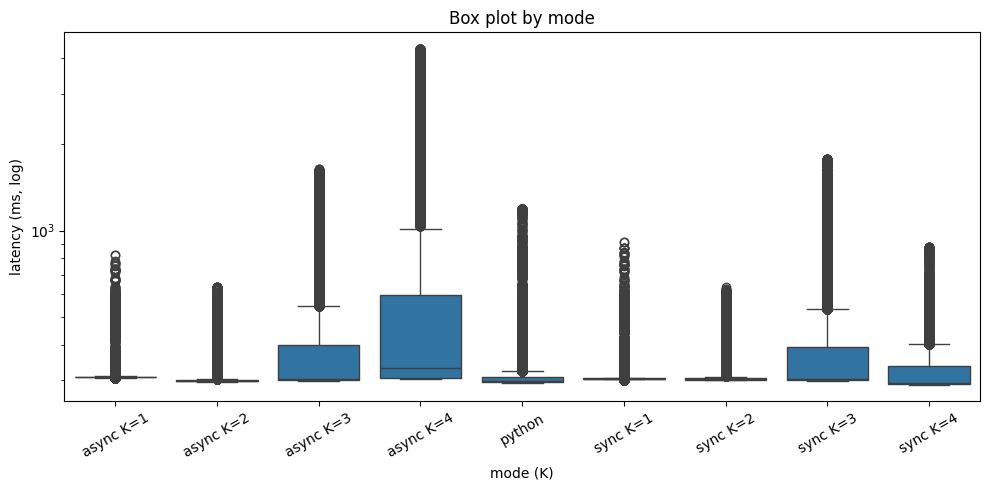

In [15]:
# Box plot by mode (includes K), date removed
dff = df
if 'df' not in globals() or df is None or df.empty:
    print('No data to plot.')
else:
    plt.figure(figsize=(10,5))
    order = sorted(df['mode_label'].dropna().unique())
    sns.boxplot(data=df, x='mode_label', y='lat', order=order, showfliers=True)
    plt.yscale('log')
    plt.xlabel('mode (K)')
    plt.ylabel('latency (ms, log)')
    plt.title('Box plot by mode')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


Conclusion

The box plots illustrate the overall shape of the distributions and immediately show tail thickening as K grows. In particular, async K=3–4 and sync K=3–4 display thick boxes and long upper tails — a sign of stability degradation under increased thread/scheduler contention.

For Python, outliers are dense and extend higher than the others; for async/sync K=1 the outliers have a similar shape but sit lower, and their density declines toward the top — extreme values occur less often.

Async/sync K=2 look like the best compromise: the smallest whisker height with a narrow box at a comparable median.

This pattern is consistent with heavy‑tailed delays along the broker → network → kernel path (interrupts/softirq, scheduler, CPU/IO contention) and with occasional TCP/TLS repackaging pauses; increasing K adds contention and raises the chance of rare long delays; Python adds interpreter/GIL overhead and runtime pauses.

For the main comparisons we therefore exclude K=3 and K=4, and continue with Python, K=1 and K=2. Box plots are useful for a quick read on “thickness,” but for tail analysis CCDF on a log–log scale is more informative: it shows P(latency ≥ x), emphasizes differences at p99/p999, is bin‑free, and compares runs with different sample counts. We will use CCDF as the primary tool for tail comparisons (and to assess improvements, including best‑of‑K).


In [32]:
# Create a filtered DataFrame for focused comparisons (exclude async/sync with K>=3, keep python)
if 'df' not in globals() or df is None or df.empty:
    print('No data to filter.')
else:
    # Robust filtering by numeric K to avoid label/whitespace mismatches
    dff = df[~((df['mode'].isin(['async','sync'])) & (df['K'].fillna(0) >= 3))].copy()
    # Show resulting modes
    print('Filtered modes:', sorted(dff['mode_label'].dropna().unique()))
    dff.head()


Filtered modes: ['async K=1', 'async K=2', 'python', 'sync K=1', 'sync K=2']


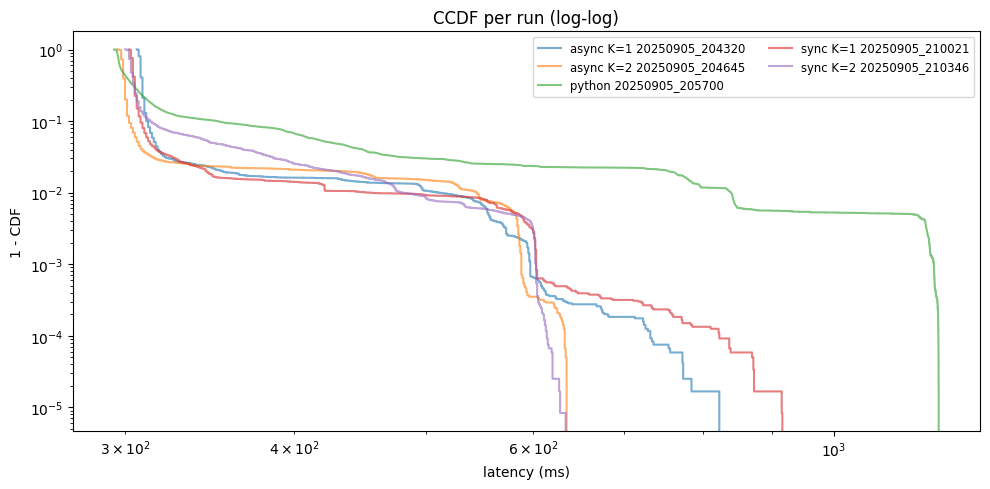

In [ ]:
# CCDF (1-CDF) in log scale per run
data = None
if 'dff' in globals() and dff is not None and not dff.empty:
    data = dff
elif 'df' in globals():
    data = df

if data is None or data.empty:
    print('No data to plot.')
else:
    plt.figure(figsize=(10,5))
    for (mode, ts), g in data.groupby(['mode_label','ts']):
        vals = np.sort(g['lat'].to_numpy())
        if vals.size == 0:
            continue
        cdf = np.arange(1, len(vals)+1) / len(vals)
        ccdf = 1 - cdf
        plt.step(vals, ccdf, where='post', alpha=0.6, label=f"{mode} {ts}")
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('latency (ms)'); plt.ylabel('1 - CDF')
    plt.title('CCDF per run (log-log)')
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout(); plt.show()


Conclusion

In the CCDF, async K=2 and sync K=2 clearly lead: their curves sit consistently to the left and below the others, i.e., the probability of large delays is minimal. Python, by contrast, is farthest to the right and highest — the heaviest tails. async/sync K=1 are close to each other and occupy a middle position between Python and K=2.

This reflects the balance between parallelism and contention: two independent connections increase the chance to obtain a packet earlier and partially decorrelate rare pauses, whereas a single stream remains vulnerable to isolated stalls along the path. Python also carries interpreter/GIL overhead. Modest parallelism improves tails, while further increasing K intensifies CPU/IO contention and thickens the distribution.